In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from collections import defaultdict

In [38]:
class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, keyword=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Load and filter filenames by keyword (if provided)
        image_filenames = sorted(os.listdir(image_dir))
        mask_filenames = sorted(os.listdir(mask_dir))

        if keyword:
            self.image_filenames = [f for f in image_filenames if keyword in f]
            self.mask_filenames = [f for f in mask_filenames if keyword in f]
        else:
            self.image_filenames = image_filenames
            self.mask_filenames = mask_filenames

        assert len(self.image_filenames) == len(self.mask_filenames), \
            "Mismatch between image and mask counts after filtering"

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = image.astype('float32') / 255.0
        mask = (mask > 0).astype('float32')

        image = torch.tensor(image).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)

        image = pad_to_multiple(image)
        mask = pad_to_multiple(mask)

        return image, mask, self.image_filenames[idx]

In [35]:
def pad_to_multiple(x, multiple=32):
    h, w = x.shape[-2], x.shape[-1]
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    return F.pad(x, (0, pad_w, 0, pad_h))

def unpad_to_shape(x, original_h, original_w):
    return x[..., :original_h, :original_w]

In [84]:
def show_prediction(model, img, mask, results_dir, filename, save=True):
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_bin = (pred > 0.5).float().squeeze().cpu().numpy()

    pred_unpadded = unpad_to_shape(pred_bin, 520, 704)
    img_unpadded = unpad_to_shape(img.squeeze(0), 520, 704)
    mask_unpadded = unpad_to_shape(mask.squeeze(0), 520, 704)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(img_unpadded, cmap='gray')
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    axs[1].imshow(mask_unpadded, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_unpadded, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')

    plt.tight_layout()

    if save:
        save_path = f"{results_dir}/{filename}_prediction.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved prediction to {save_path}")
    else:
        plt.show()
    plt.close(fig)

In [27]:
model_dir = "../results/passive_learning_partial_training_aws_reproducible/models"

## Model Loading

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def load_model_from_checkpoint(path, device='cuda'):
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
        activation="sigmoid"
    ).to(device)
    
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

In [81]:
train_ds = CellSegmentationDataset("../data/images_train", "../data/masks_train")

In [82]:
initial_size = 100
increment = 200

max_size = int(0.5 * len(train_ds))
n_simulations = 5

In [83]:
dataset_sizes = list(range(initial_size, max_size + 1, increment))

# Test set by cell type

## Function for all cell types

In [66]:
def run_predictions_for_cell_type(cell_type):
    test_ds = CellSegmentationDataset("../data/images_test", "../data/masks_test", keyword= cell_type)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
    test_results = defaultdict(list)

    for sim in range(n_simulations):
        for size in sorted(dataset_sizes):
            model_path = os.path.join(model_dir, f"model_sim{sim}_size{size}.pt")
            model = load_model_from_checkpoint(model_path, device=device)

            dice_scores = []

            with torch.no_grad():
                for img, mask, fname in test_loader:
                    img, mask = img.to(device), mask.to(device)

                    pred = model(img)
                    pred_bin = (pred > 0.5).float()

                    # dice = dice_coefficient(pred_binary, mask).item()
                    inter = (pred_bin * mask).sum()
                    union = pred_bin.sum() + mask.sum()
                    dice = (2 * inter) / (union + 1e-8)
                    dice_scores.append(dice)

                    # base_name = os.path.splitext(os.path.basename(fname[0]))[0]
                    # file_name = f"{base_name}_sim_{sim}_train_size_{size}.png"
                    # show_prediction(model, img, mask, results_dir, filename=file_name)

            avg_dice = np.mean(dice_scores)
            test_results[size].append(avg_dice)
            print(f" Avg Dice for sim {sim}, size {size}: {avg_dice:.4f}")
    test_df = pd.DataFrame(test_results)
    return test_df

In [67]:
def plot_res(cell_type, test_df):
    plot_dir = f"../cellTypeData/{cell_type}"
    os.makedirs(plot_dir, exist_ok = True)
    test_df.to_csv(f"{plot_dir}/TestDiceScores.csv", index=False)
    # Compute mean and std
    mean_scores = test_df.mean()
    std_scores = test_df.std()

    # Plot
    plt.figure(figsize=(10, 5))
    sizes = sorted(test_results.keys())
    plt.plot(sizes, mean_scores, label='Average Test Dice', color='orange', marker='o')
    plt.fill_between(sizes, mean_scores - std_scores, mean_scores + std_scores, color='orange', alpha=0.3)
    plt.xlabel("Training Set Size")
    plt.ylabel("Dice Score")
    plt.title(f"Performance on {cell_type} Cell Type: Dice Score by Training Set Size")
    plt.grid(True)
    plt.legend()
    plt.legend(loc="lower right", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/dice_vs_train_size.png")
    plt.show()

In [72]:
# cell_types = ["BT474", "BV2", "Huh7", "MCF7", "SHSY5Y", "SkBr3", "SKOV3"]
cell_types = ["BT474", "BV2", "MCF7", "SHSY5Y"] # if short on time

In [71]:
test_res = {}
for cell in cell_types:
    print(f"Processing cell type {cell}")
    test_res[cell] = run_predictions_for_cell_type(cell)
    print(f"Finished processing {cell}")

Processing cell typeBT474
 Avg Dice for sim 0, size 100: 0.7679
 Avg Dice for sim 0, size 300: 0.8493
 Avg Dice for sim 0, size 500: 0.8694
 Avg Dice for sim 0, size 700: 0.8808
 Avg Dice for sim 0, size 900: 0.8816
 Avg Dice for sim 0, size 1100: 0.8910
 Avg Dice for sim 0, size 1300: 0.8879
 Avg Dice for sim 0, size 1500: 0.8927
 Avg Dice for sim 1, size 100: 0.8539
 Avg Dice for sim 1, size 300: 0.8748
 Avg Dice for sim 1, size 500: 0.8873
 Avg Dice for sim 1, size 700: 0.8853
 Avg Dice for sim 1, size 900: 0.8722
 Avg Dice for sim 1, size 1100: 0.8926
 Avg Dice for sim 1, size 1300: 0.8869
 Avg Dice for sim 1, size 1500: 0.8903
 Avg Dice for sim 2, size 100: 0.8246
 Avg Dice for sim 2, size 300: 0.8697
 Avg Dice for sim 2, size 500: 0.8845
 Avg Dice for sim 2, size 700: 0.8790
 Avg Dice for sim 2, size 900: 0.8889
 Avg Dice for sim 2, size 1100: 0.8866
 Avg Dice for sim 2, size 1300: 0.8897
 Avg Dice for sim 2, size 1500: 0.8902
 Avg Dice for sim 3, size 100: 0.8265
 Avg Dice for s

KeyboardInterrupt: 

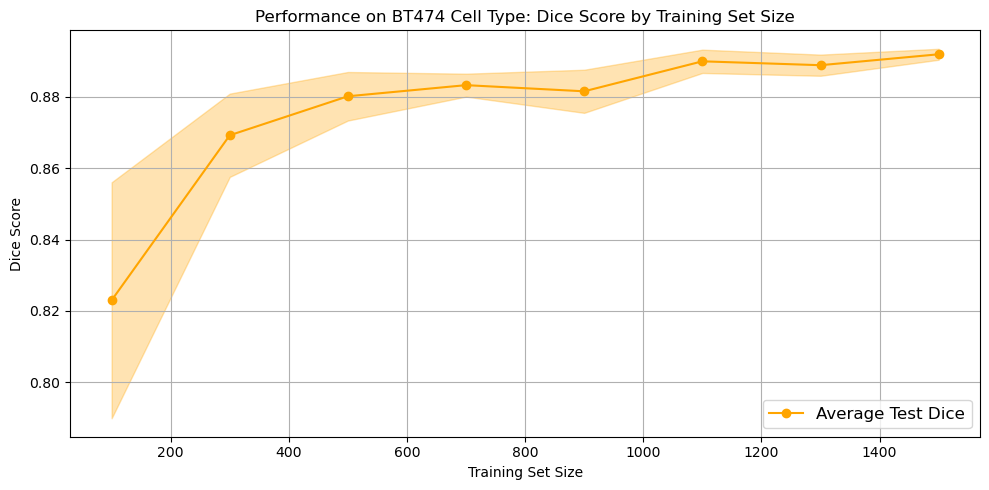

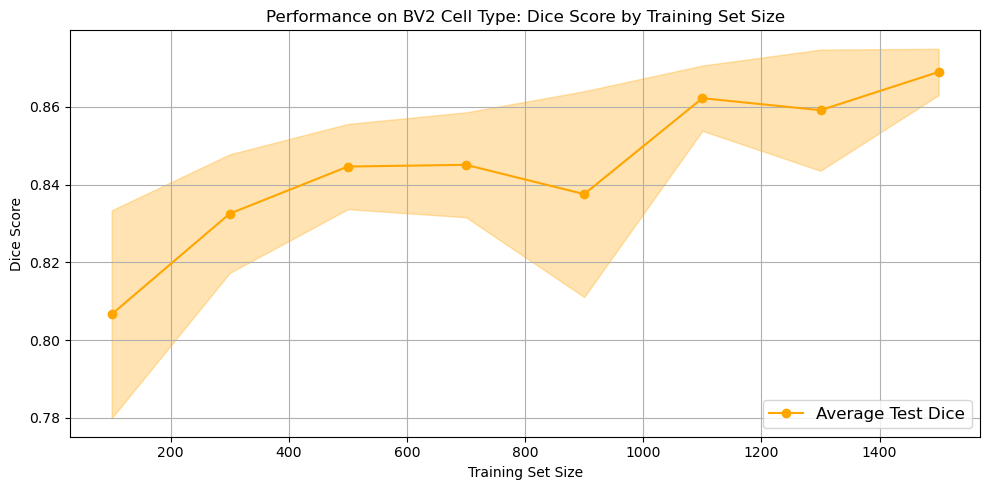

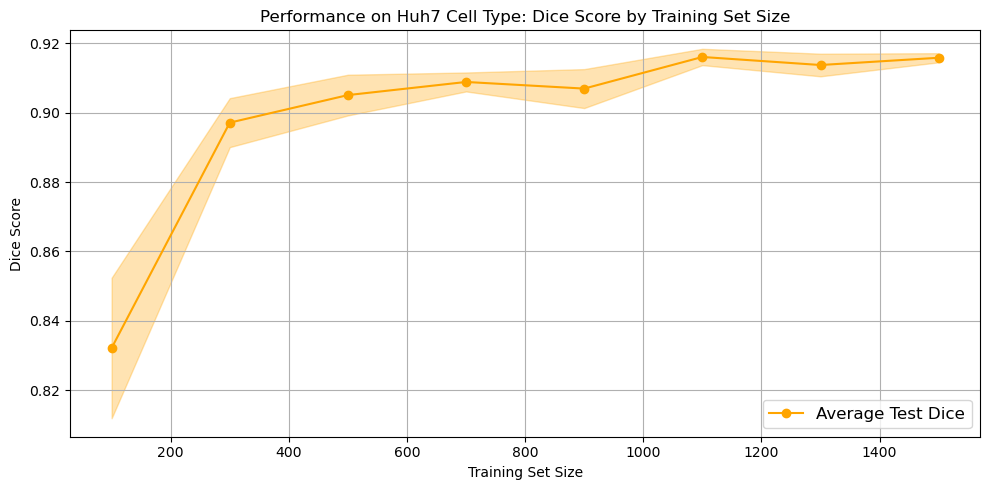

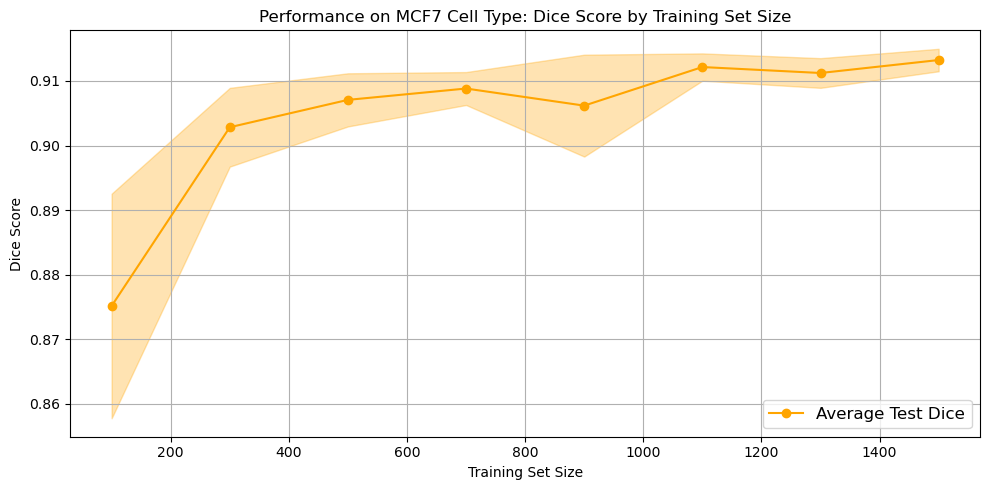

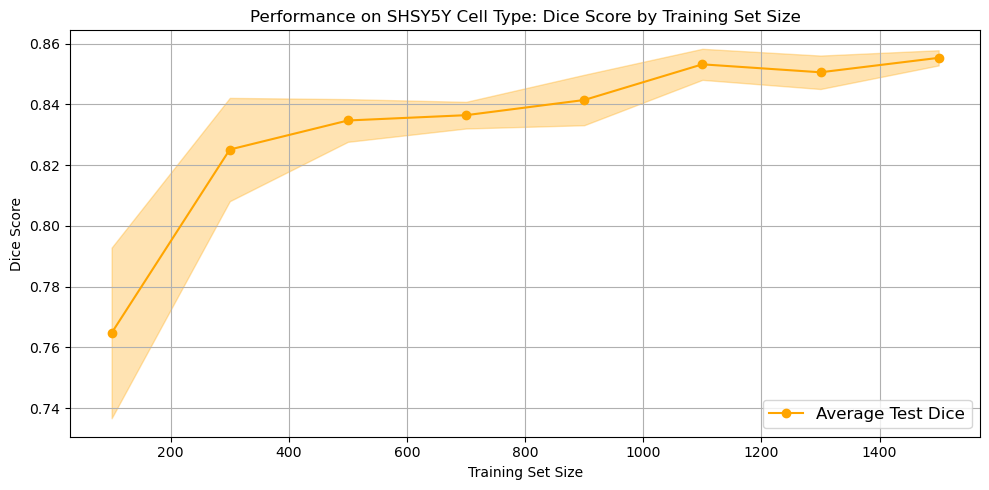

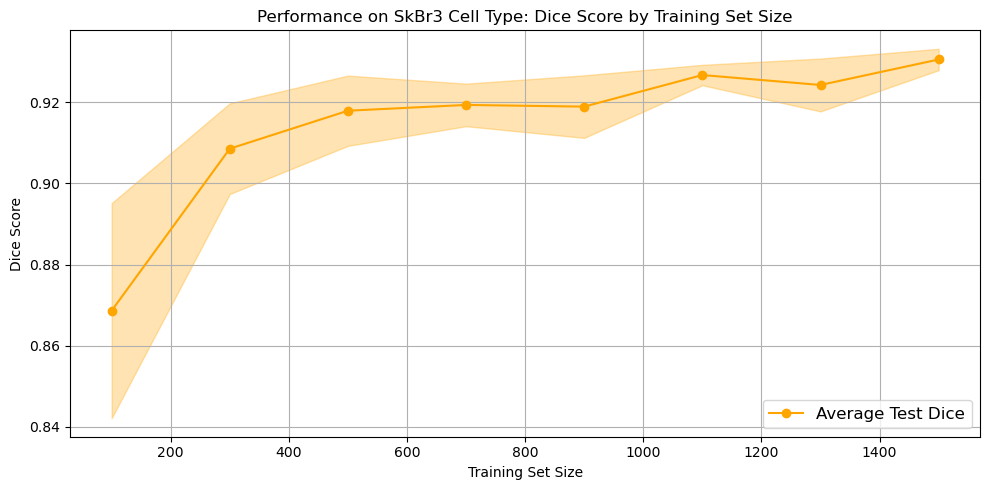

In [73]:
for cell in cell_types:
    plot_res(cell, test_res[cell])

## Testing on new test set

In [ ]:
val_ds =  CellSegmentationDataset("../data/images_val", "../data/masks_val")

## Single cell Type: Don't run

In [48]:
keyword =  "A172"

In [20]:
#val_ds =  CellSegmentationDataset("../data/images_val", "../data/masks_val", keyword= "A172")
train_ds = CellSegmentationDataset("../data/images_train", "../data/masks_train")
test_ds = CellSegmentationDataset("../data/images_test", "../data/masks_test", keyword = keyword)

In [8]:
test_ds.image_filenames

['A172_Phase_C7_1_00d00h00m_1.png',
 'A172_Phase_C7_1_00d00h00m_2.png',
 'A172_Phase_C7_1_00d00h00m_3.png',
 'A172_Phase_C7_1_00d00h00m_4.png',
 'A172_Phase_C7_1_00d04h00m_1.png',
 'A172_Phase_C7_1_00d04h00m_2.png',
 'A172_Phase_C7_1_00d04h00m_3.png',
 'A172_Phase_C7_1_00d04h00m_4.png',
 'A172_Phase_C7_1_00d08h00m_1.png',
 'A172_Phase_C7_1_00d08h00m_2.png',
 'A172_Phase_C7_1_00d08h00m_3.png',
 'A172_Phase_C7_1_00d08h00m_4.png',
 'A172_Phase_C7_1_00d12h00m_1.png',
 'A172_Phase_C7_1_00d12h00m_2.png',
 'A172_Phase_C7_1_00d12h00m_3.png',
 'A172_Phase_C7_1_00d12h00m_4.png',
 'A172_Phase_C7_1_00d16h00m_1.png',
 'A172_Phase_C7_1_00d16h00m_2.png',
 'A172_Phase_C7_1_00d16h00m_3.png',
 'A172_Phase_C7_1_00d16h00m_4.png',
 'A172_Phase_C7_1_00d20h00m_1.png',
 'A172_Phase_C7_1_00d20h00m_2.png',
 'A172_Phase_C7_1_00d20h00m_3.png',
 'A172_Phase_C7_1_00d20h00m_4.png',
 'A172_Phase_C7_1_01d00h00m_1.png',
 'A172_Phase_C7_1_01d00h00m_2.png',
 'A172_Phase_C7_1_01d00h00m_3.png',
 'A172_Phase_C7_1_01d00h00m_

In [30]:
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [41]:
def show_prediction(model, img, mask, results_dir, filename, save=True):
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_bin = (pred > 0.5).float().squeeze().cpu().numpy()

    pred_unpadded = unpad_to_shape(pred_bin, 520, 704)
    img_unpadded = unpad_to_shape(img.squeeze(0), 520, 704)
    mask_unpadded = unpad_to_shape(mask.squeeze(0), 520, 704)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(img_unpadded, cmap='gray')
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    axs[1].imshow(mask_unpadded, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_unpadded, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')

    plt.tight_layout()

    if save:
        save_path = f"{results_dir}/{filename}_prediction.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved prediction to {save_path}")
    else:
        plt.show()
    plt.close(fig)

### Predictions

In [21]:
initial_size = 100
increment = 200

max_size = int(0.5 * len(train_ds))
n_simulations = 5

In [26]:
dataset_sizes = list(range(initial_size, max_size + 1, increment))

In [42]:
test_results = defaultdict(list)

for sim in range(n_simulations):
    for size in sorted(dataset_sizes):
        model_path = os.path.join(model_dir, f"model_sim{sim}_size{size}.pt")
        model = load_model_from_checkpoint(model_path, device=device)

        dice_scores = []

        with torch.no_grad():
            for img, mask, fname in test_loader:
                img, mask = img.to(device), mask.to(device)

                pred = model(img)
                pred_bin = (pred > 0.5).float()

                # dice = dice_coefficient(pred_binary, mask).item()
                inter = (pred_bin * mask).sum()
                union = pred_bin.sum() + mask.sum()
                dice = (2 * inter) / (union + 1e-8)
                dice_scores.append(dice)

                # base_name = os.path.splitext(os.path.basename(fname[0]))[0]
                # file_name = f"{base_name}_sim_{sim}_train_size_{size}.png"
                # show_prediction(model, img, mask, results_dir, filename=file_name)

        avg_dice = np.mean(dice_scores)
        test_results[size].append(avg_dice)
        print(f" Avg Dice for sim {sim}, size {size}: {avg_dice:.4f}")

 Avg Dice for sim 0, size 100: 0.8812
 Avg Dice for sim 0, size 300: 0.9360
 Avg Dice for sim 0, size 500: 0.9454
 Avg Dice for sim 0, size 700: 0.9486
 Avg Dice for sim 0, size 900: 0.9512
 Avg Dice for sim 0, size 1100: 0.9548
 Avg Dice for sim 0, size 1300: 0.9523
 Avg Dice for sim 0, size 1500: 0.9566
 Avg Dice for sim 1, size 100: 0.9325
 Avg Dice for sim 1, size 300: 0.9480
 Avg Dice for sim 1, size 500: 0.9534
 Avg Dice for sim 1, size 700: 0.9514
 Avg Dice for sim 1, size 900: 0.9361
 Avg Dice for sim 1, size 1100: 0.9554
 Avg Dice for sim 1, size 1300: 0.9510
 Avg Dice for sim 1, size 1500: 0.9531
 Avg Dice for sim 2, size 100: 0.9132
 Avg Dice for sim 2, size 300: 0.9454
 Avg Dice for sim 2, size 500: 0.9514
 Avg Dice for sim 2, size 700: 0.9501
 Avg Dice for sim 2, size 900: 0.9536
 Avg Dice for sim 2, size 1100: 0.9526
 Avg Dice for sim 2, size 1300: 0.9540
 Avg Dice for sim 2, size 1500: 0.9552
 Avg Dice for sim 3, size 100: 0.9122
 Avg Dice for sim 3, size 300: 0.9495
 Av

In [43]:
test_results

defaultdict(list,
            {100: [np.float32(0.88118976),
              np.float32(0.93247235),
              np.float32(0.91318434),
              np.float32(0.9122388),
              np.float32(0.91770214)],
             300: [np.float32(0.9360026),
              np.float32(0.9480023),
              np.float32(0.94535714),
              np.float32(0.9494699),
              np.float32(0.94859517)],
             500: [np.float32(0.9453657),
              np.float32(0.953428),
              np.float32(0.9514387),
              np.float32(0.9484744),
              np.float32(0.9499798)],
             700: [np.float32(0.9485829),
              np.float32(0.95142126),
              np.float32(0.9500731),
              np.float32(0.9492849),
              np.float32(0.9532396)],
             900: [np.float32(0.9512285),
              np.float32(0.9361116),
              np.float32(0.95364964),
              np.float32(0.9521175),
              np.float32(0.9516788)],
             1100: [

In [52]:
plot_dir = f"../cellTypeData/{keyword}"
os.makedirs(plot_dir, exist_ok = True)

In [51]:
help(os.makedirs)

Help on function makedirs in module os:

makedirs(name, mode=511, exist_ok=False)
    makedirs(name [, mode=0o777][, exist_ok=False])

    Super-mkdir; create a leaf directory and all intermediate ones.  Works like
    mkdir, except that any intermediate path segment (not just the rightmost)
    will be created if it does not exist. If the target directory already
    exists, raise an OSError if exist_ok is False. Otherwise no exception is
    raised.  This is recursive.



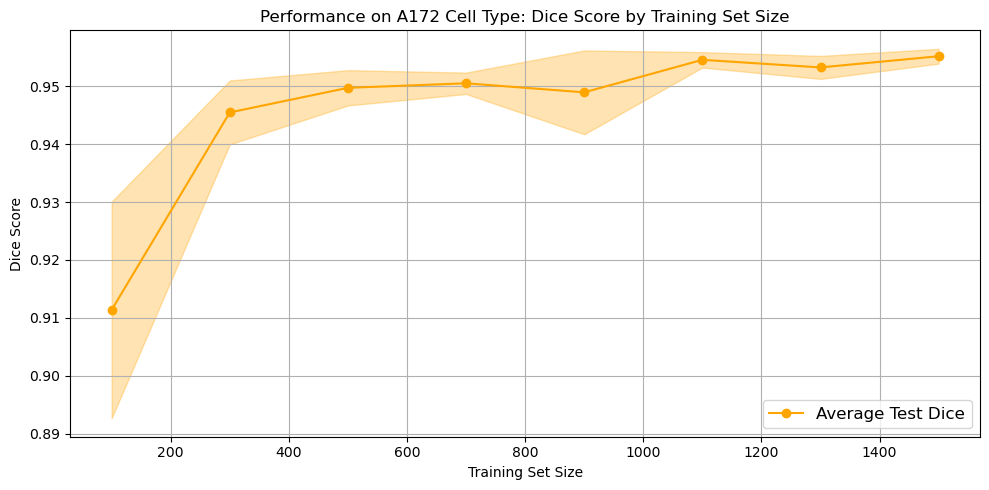

In [60]:
test_df = pd.DataFrame(test_results)
test_df.to_csv(f"{plot_dir}/TestDiceScores.csv", index=False)

# Compute mean and std
mean_scores = test_df.mean()
std_scores = test_df.std()

# Plot
plt.figure(figsize=(10, 5))
sizes = sorted(test_results.keys())
plt.plot(sizes, mean_scores, label='Average Test Dice', color='orange', marker='o')
plt.fill_between(sizes, mean_scores - std_scores, mean_scores + std_scores, color='orange', alpha=0.3)
plt.xlabel("Training Set Size")
plt.ylabel("Dice Score")
plt.title(f"Performance on {keyword} Cell Type: Dice Score by Training Set Size")
plt.grid(True)
plt.legend()
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.savefig(f"{plot_dir}/dice_vs_train_size.png")
plt.show()